<a href="https://colab.research.google.com/github/JJJuliaa/Fraud_Analysis/blob/master/Creditcard_Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install catboost

     |████████████████████████████████| 65.9MB 53kB/s 


In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

In [5]:
from google.colab import files
uploaded = files.upload()

Saving creditcard.csv to creditcard (1).csv


In [8]:
import io
df = pd.read_csv(io.BytesIO(uploaded['creditcard.csv']))

In [18]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [25]:
print('This dataset has',df.shape[0], 'rows and ', df.shape[1],'columns') 
print('This dataset contains data collected in two consecutive days (172792 seconds)')

This dataset has 284807 rows and  31 columns
This dataset contains data collected in two consecutive days (172792 seconds)


In [ ]:
Missing = df.isnull().sum()
Percent = (df.isnull().sum()/df.count()*100)
print(pd.concat([Missing, Percent],axis=1,keys=['Missing','Percent']).transpose())
print('There is no missing values in the dataset')

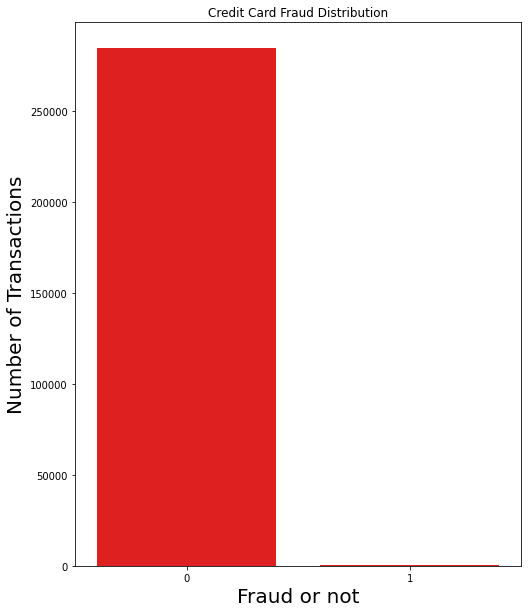

In [55]:
plt.figure(figsize=(8,10))
p1=sns.countplot(x='Class',data=df,color='red')
p1.set_title('Credit Card Fraud Distribution')
p1.set_xlabel('Fraud or not',fontsize=20)
p1.set_ylabel('Number of Transactions',fontsize=20)
plt.show()

In [57]:
print('This is a highly skewed data with a fraud incidence of 0.172%')

This is a highly skewed data with a fraud incidence of 0.172%


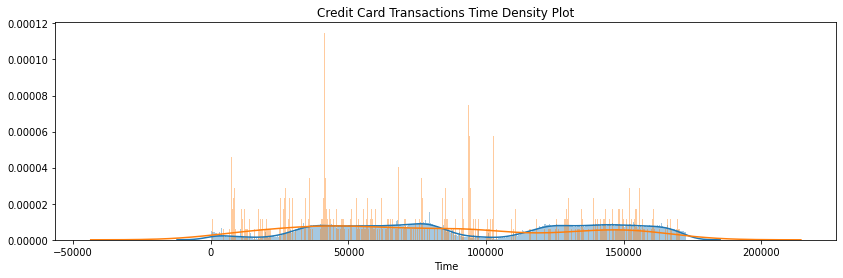

In [68]:
Nofraud=df.loc[df['Class']==0]['Time']
Fraud=df.loc[df['Class']==1]['Time']
hist = [Nofraud,Fraud]
plt.figure(figsize = (14,4))
plt.title('Credit Card Transactions Time Density Plot')
sns.set_color_codes("pastel")
sns.distplot(Nofraud,kde=True,bins=480)
sns.distplot(Fraud,kde=True,bins=480)
plt.show()

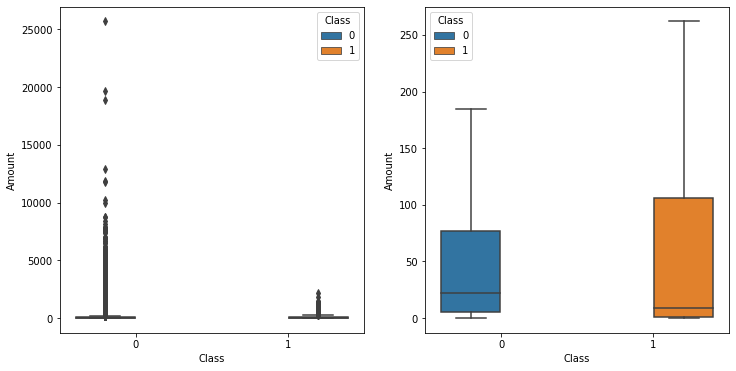

In [74]:
g, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
P1 = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=df,showfliers=True)
P2 = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=df,showfliers=False)
plt.show()

In [77]:
temp=df[['Amount','Class']].copy()
Nofraud=temp.loc[temp['Class']==0]['Amount']
Fraud=temp.loc[temp['Class']==1]['Amount']
Nofraud.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [78]:
Fraud.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

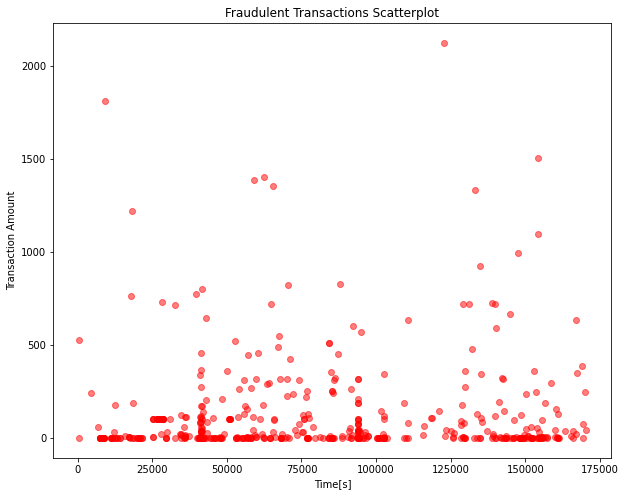

In [85]:
fraud = df.loc[df['Class'] == 1]
plt.figure(figsize=(10,8))
plt.scatter(x=fraud['Time'],y = fraud['Amount'],c='red',alpha=0.5)
plt.title('Fraudulent Transactions Scatterplot')
plt.xlabel('Time[s]')
plt.ylabel('Transaction Amount')
plt.show()

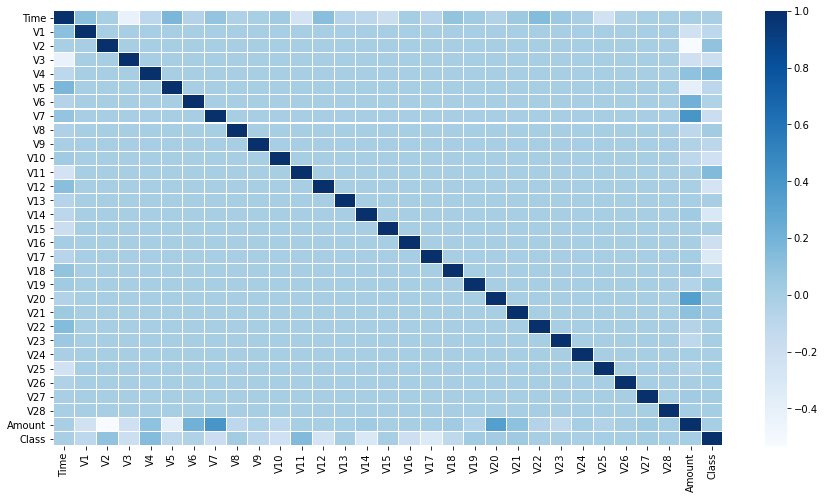

In [95]:
plt.figure(figsize=(15,8))
corr=df.corr()
sns.heatmap(corr,xticklabels=corr.columns, yticklabels=corr.columns, linewidths=0.05,cmap='Blues')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning:

Data must have variance to compute a kernel density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning:

Data must have variance to compute a kernel density estimate.



<Figure size 432x288 with 0 Axes>

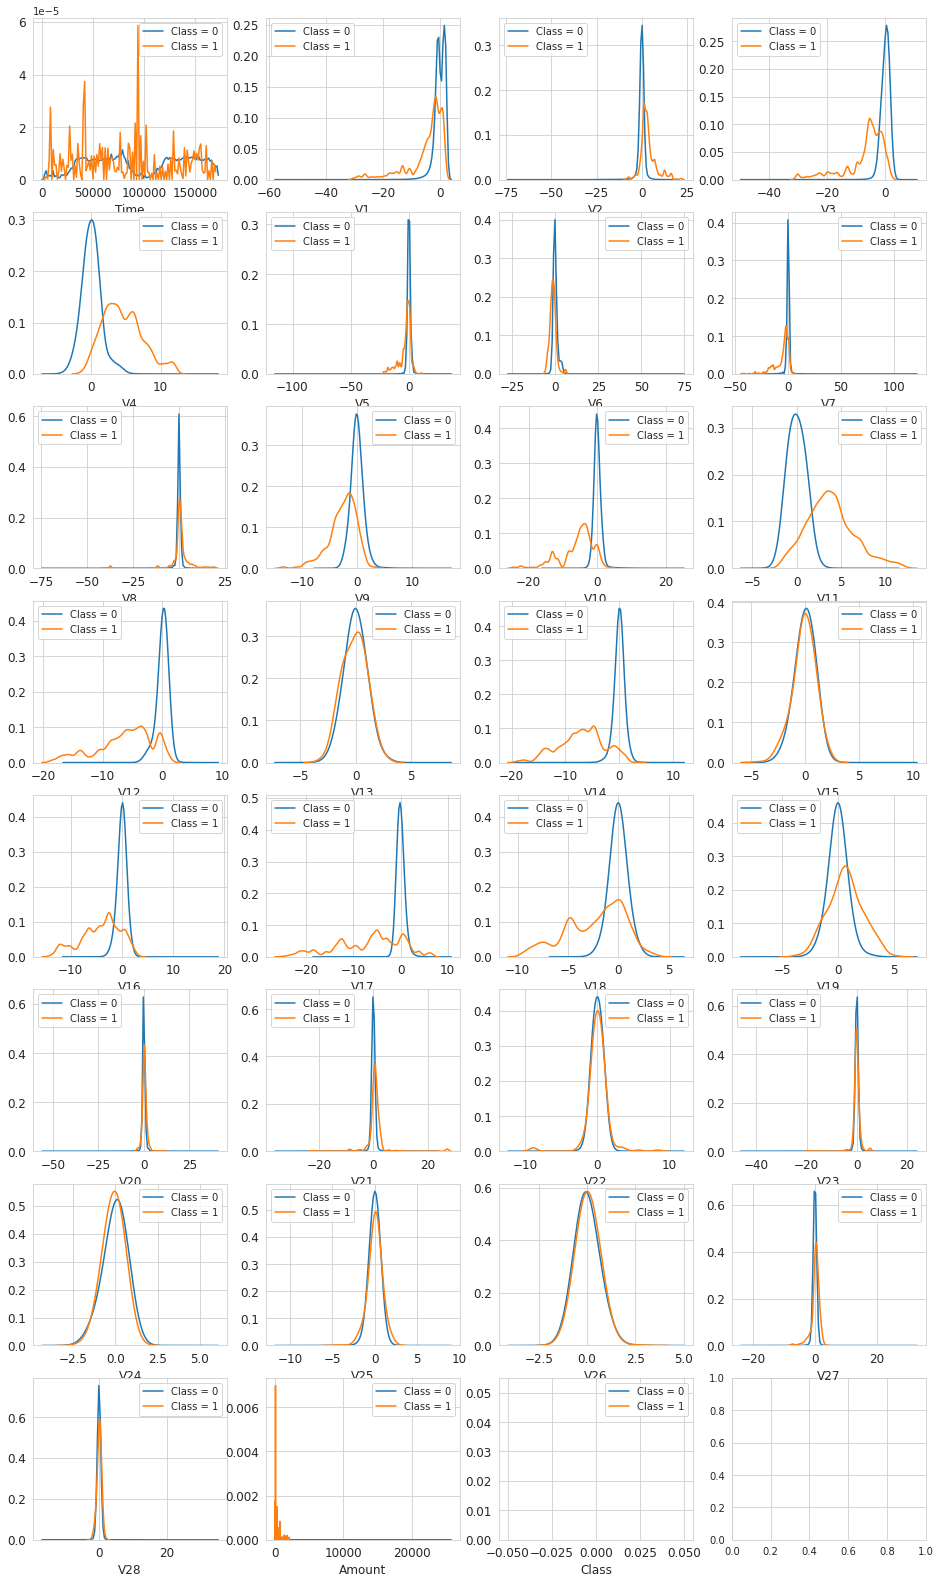

In [98]:
var = df.columns.values

i = 0
t0 = df.loc[df['Class'] == 0]
t1 = df.loc[df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [118]:
target = 'Class'
predictors=['Time','V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount']

In [119]:
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [120]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [121]:
clf.fit(train_df[predictors],train_df[target].values)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=2018, verbose=False,
                       warm_start=False)

In [122]:
pred = clf.predict(valid_df[predictors])

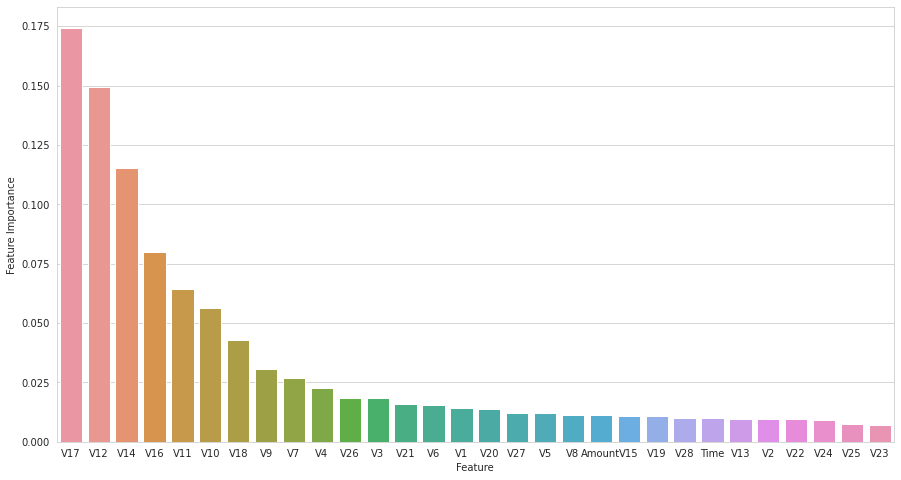

In [124]:
temp=pd.DataFrame({'Feature':predictors,'Feature Importance': clf.feature_importances_})
temp=temp.sort_values(by='Feature Importance',ascending=False)
plt.figure(figsize=(15,8))
p=sns.barplot(x='Feature',y='Feature Importance',data=temp)
plt.show()

In [126]:
roc_auc_score(valid_df[target].values,pred)

0.8528641975628091

In [127]:
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [128]:
clf.fit(train_df[predictors], train_df[target].values)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.8,
                   n_estimators=100, random_state=2018)

In [131]:
pred2 = clf.predict(valid_df[predictors])

In [132]:
roc_auc_score(valid_df[target].values,pred2)

0.8332343604519027

In [133]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)


In [135]:
clf.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 770ms	remaining: 6m 24s
50:	total: 33.6s	remaining: 4m 55s
100:	total: 1m 6s	remaining: 4m 20s
150:	total: 1m 36s	remaining: 3m 43s
200:	total: 2m 7s	remaining: 3m 9s
250:	total: 2m 37s	remaining: 2m 36s
300:	total: 3m 8s	remaining: 2m 4s
350:	total: 3m 41s	remaining: 1m 33s
400:	total: 4m 13s	remaining: 1m 2s
450:	total: 4m 44s	remaining: 31s
499:	total: 5m 15s	remaining: 0us


In [136]:
pred3 = clf.predict(valid_df[predictors])

In [137]:
roc_auc_score(valid_df[target].values, pred3)

0.8577991493075996

In [138]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
wl = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [140]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                wl, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.889519	valid-auc:0.852739
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.939441	valid-auc:0.881959
[100]	train-auc:0.944161	valid-auc:0.890967
[150]	train-auc:0.977186	valid-auc:0.964228
[200]	train-auc:0.990128	valid-auc:0.982695
[250]	train-auc:0.994442	valid-auc:0.986025
[300]	train-auc:0.996408	valid-auc:0.984589
Stopping. Best iteration:
[258]	train-auc:0.995034	valid-auc:0.986645



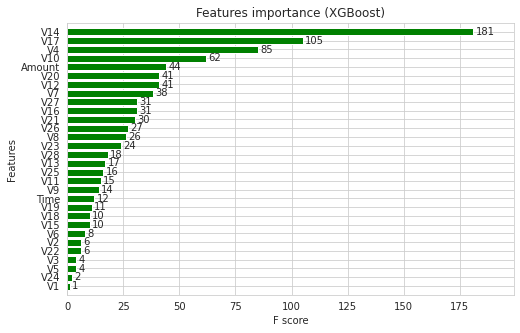

In [141]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

In [142]:
pred4 = model.predict(dtest)

In [143]:
roc_auc_score(test_df[target].values, pred4)

0.9770317611058352